# Experiments for asynchronous gate and expert training with different datasets

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import matplotlib.cm as cm  # colormaps

%matplotlib inline

In [2]:
import seaborn as sns
import numpy as np
from statistics import mean
from math import ceil, sin, cos, radians
from collections import OrderedDict
import os
import pandas as pd
from pprint import pprint
from copy import deepcopy

In [3]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset
import torchvision.transforms.functional as TF

In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print('device', device)
else:
    device = torch.device("cpu")
    print('device', device)

device cuda:0


In [5]:
# import MoE expectation model. All experiments for this dataset are done with the expectation model as it
# provides the best guarantee of interpretable task decompositions
from moe_models.moe_expectation_model import moe_expectation_model
from moe_models.moe_stochastic_model import moe_stochastic_model
from moe_models.moe_no_gate_model import moe_no_gate_model
from helper.moe_models import cross_entropy_loss, stochastic_loss
from helper.visualise_results import *

device cuda:0
device cuda:0
device cuda:0
device cuda:0
device cuda:0
device cuda:0


### NOTE: Pre-trained models are provided to check the results of all the experiments if you do not have the time to train all the models. 

## Load MNIST dataset

In [6]:
# Paths to where the trained models and figures will be stored. You can change this as you see fit.
fig_path = '../figures'
model_path = '../models'
pre_trained_model_path = '../models/pre_trained'

if not os.path.exists(fig_path):
    os.mkdir(fig_path)
if not os.path.exists(model_path):
    os.mkdir(model_path)

In [7]:
import torchvision.transforms as transforms

# transforms: Convert PIL image to tensors and normalize
mnist_transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))]) 

In [8]:
trainsize = 60000
testsize = 10000

In [9]:
# Load and split data as train and test
trainset = torchvision.datasets.MNIST('./data',
    download=True,
    train=True,
    transform=mnist_transform,
    target_transform = torch.tensor,                                 
    )
testset = torchvision.datasets.MNIST('./data',
    download=True,
    train=False,
    transform=mnist_transform,
    target_transform = torch.tensor,)

batch_size = 512
# dataloaders
trainloader = torch.utils.data.DataLoader(torch.utils.data.Subset(trainset, range(trainsize)), 
                                          batch_size=batch_size,
                                          shuffle=True)

testloader = torch.utils.data.DataLoader(torch.utils.data.Subset(testset, range(testsize)),
                                         batch_size=testsize,
                                         shuffle=False)
num_classes = 10
classes_mnist = ['0','1','2','3','4','5','6','7','8','9']

image, label = trainset.__getitem__(0)
print('Image shape', image.shape)
print('Train samples ', len(trainset))
print('Test samples ', len(testset))


Image shape torch.Size([1, 28, 28])
Train samples  60000
Test samples  10000


tensor(-0.4242) tensor(2.8215)
Data samples


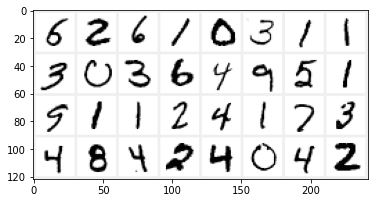

In [10]:
# create grid of images
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(min(images[0].flatten()),max(images[0].flatten()) )
img_grid = torchvision.utils.make_grid(images[0:32])

print('Data samples')
# show images
imshow(img_grid, one_channel=True)


### Create combined rotated and unrotated MNIST image dataset of the digits 1-5

In [11]:
from PIL import Image
def rotate_dataset(d, rotation):
    result = torch.FloatTensor(d.size(0), 1, 28,28)
    tensor = transforms.ToTensor()
    norm = transforms.Normalize((0.1307,), (0.3081,))
    
    for i in range(d.size(0)):
        img = Image.fromarray(d[i].numpy(), mode='L')
        result[i] = norm(TF.rotate(tensor(img), rotation))
    return result

In [12]:
rot = 90

rot_train = rotate_dataset(trainset.data, rot)
rot_test= rotate_dataset(testset.data, rot)

In [13]:
# Function to extract subset of classes from the datasets
def filter_classes(classes_sub, classes_full, size, targets):
    print(classes_sub)
    start = 0
    labels = targets
    index = []
    per_class_size = ceil(size/len(classes_sub))
    for t in classes_sub:
        i = classes_full.index(t)
        index += list(np.where(labels == i)[0])[0:per_class_size]
    return index[0:size]

In [14]:
mnist_indices_train = filter_classes(classes_mnist[0:5], classes_mnist, int(trainsize/2), trainset.targets)
mnist_indices_test = filter_classes(classes_mnist[0:5], classes_mnist, int(testsize/2), testset.targets)

['0', '1', '2', '3', '4']
['0', '1', '2', '3', '4']


In [15]:
# shifting the labels by 5 to avoid overlap when selecting digits 1-5
classes_rot_mnist = ['5','6','7','8','9','10','11','12','13','14']

In [16]:
rot_trainset = TensorDataset(rot_train, trainset.targets+5)
rot_testset = TensorDataset(rot_test, testset.targets+5)

In [17]:
len(rot_trainset)
len(trainset)

60000

In [18]:
rot_trainloader = torch.utils.data.DataLoader(torch.utils.data.Subset(rot_trainset,mnist_indices_train), batch_size=batch_size,
                                          shuffle=True, num_workers=1, pin_memory=True)
rot_testloader = torch.utils.data.DataLoader(torch.utils.data.Subset(rot_trainset,mnist_indices_test), batch_size=len(mnist_indices_test),
                                         shuffle=True, num_workers=1, pin_memory=True)

Data samples


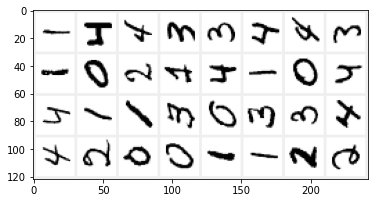

In [19]:
# create grid of images
dataiter = iter(rot_trainloader)
images, labels = dataiter.next()
img_grid = torchvision.utils.make_grid(images[0:32])

print('Data samples')
# show images
imshow(img_grid, one_channel=True)


In [20]:
rot_unrot_trainset = torch.utils.data.ConcatDataset([torch.utils.data.Subset(trainset,mnist_indices_train), 
                                                 torch.utils.data.Subset(rot_trainset,mnist_indices_train)])
rot_unrot_testset = torch.utils.data.ConcatDataset([torch.utils.data.Subset(testset,mnist_indices_test),
                                                torch.utils.data.Subset(rot_testset,mnist_indices_test)])

In [21]:
rot_unrot_trainloader = torch.utils.data.DataLoader(rot_unrot_trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=1, pin_memory=True)
rot_unrot_testloader = torch.utils.data.DataLoader(rot_unrot_testset, batch_size=len(rot_unrot_testset),
                                         shuffle=True, num_workers=1, pin_memory=True)

In [22]:
classes_rot_unrot = list(range(5))+['rot '+str(i) for i in range(5)]
classes_rot_unrot

[0, 1, 2, 3, 4, 'rot 0', 'rot 1', 'rot 2', 'rot 3', 'rot 4']

Data samples


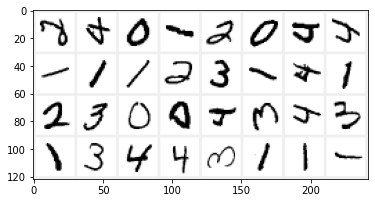

In [23]:
# create grid of images
dataiter = iter(rot_unrot_trainloader)
images, labels = dataiter.next()
img_grid = torchvision.utils.make_grid(images[0:32])

print('Data samples')
# show images
imshow(img_grid, one_channel=True)


## FMNIST dataset

In [24]:
# transforms: Convert PIL image to tensors and normalize
fmnist_transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.2859,), (0.3530,))]) 

In [25]:
fmnist_trainset = torchvision.datasets.FashionMNIST('data', transform=fmnist_transform, train=True, download=True)

In [26]:
fmnist_testset = torchvision.datasets.FashionMNIST('data',transform=fmnist_transform, train=False)

In [27]:
image, label = fmnist_trainset.__getitem__(0)
print('Image shape', image.shape)
print('Train samples ', len(fmnist_trainset))
print('Test samples ', len(fmnist_testset))

Image shape torch.Size([1, 28, 28])
Train samples  60000
Test samples  10000


In [28]:
fmnist_trainloader = torch.utils.data.DataLoader(torch.utils.data.Subset(fmnist_trainset, range(trainsize)), batch_size=batch_size,
                                          shuffle=True, num_workers=0, pin_memory=True)
fmnist_testloader = torch.utils.data.DataLoader(torch.utils.data.Subset(fmnist_testset, range(testsize)), batch_size=testsize,
                                         shuffle=True, num_workers=0, pin_memory=True)

In [29]:
classes_fmnist = ['t-shirt', 'Trouser', 'Pullover','Dress','Coat','Sandal',
                  'Shirt','Sneaker','Bag','Ankle boot']

Data samples


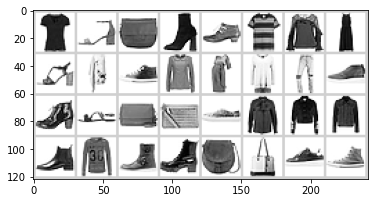

In [30]:
# create grid of images
dataiter = iter(fmnist_trainloader)
images, labels = dataiter.next()
img_grid = torchvision.utils.make_grid(images[0:32].view(-1, 1, 28, 28).type(torch.float))

print('Data samples')
# show images
imshow(img_grid, one_channel=True)

## Create combined FMNIST and MNIST dataset

In [31]:
# Since we are combining the fashion mnist and mnist data that have the same numerical labels from 0-9 
# we want to offset the mnist target so there is no overlap of the labels
def target_transform(target):
    return target+2

In [32]:
mnist_trainset = torchvision.datasets.MNIST('data', transform=mnist_transform, target_transform=target_transform, train=True, download=True)

In [33]:
mnist_testset = torchvision.datasets.MNIST('data',transform=mnist_transform, target_transform=target_transform, train=False)

In [34]:
# Combined fmnist and mnist classes. 
classes_fmnist_mnist = classes_fmnist[0:6]+classes_mnist[4:10]
print('classes_fmnist_mnist', classes_fmnist_mnist)

classes_fmnist_mnist ['t-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', '4', '5', '6', '7', '8', '9']


In [35]:
# Function to extract subset of classes from the datasets
def filter_classes(classes_sub, classes_full, size, data):
    print(classes_sub)
    start = 0
    labels = data.targets
    index = []
    per_class_size = ceil(size/len(classes_sub))
    for t in classes_sub:
        i = classes_full.index(t)
        index += list(np.where(labels == i)[0])[0:per_class_size]
    return index[0:size]

In [36]:
# Get the data for first 6 classes of fmnist dataset
fmnist_indices_train = filter_classes(classes_fmnist[0:6], classes_fmnist, int(trainsize/2), fmnist_trainset)
fmnist_indices_test = filter_classes(classes_fmnist[0:6], classes_fmnist, int(testsize/2), fmnist_testset)

['t-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal']
['t-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal']


In [37]:
fmnist_trainset.targets[fmnist_indices_train]

tensor([0, 0, 0,  ..., 5, 5, 5])

In [38]:
# Get the data for last 6 classes of fmnist dataset
mnist_indices_train = filter_classes(classes_mnist[4:], classes_mnist, int(trainsize/2), mnist_trainset)
mnist_indices_test = filter_classes(classes_mnist[4:], classes_mnist, int(testsize/2), mnist_testset)

['4', '5', '6', '7', '8', '9']
['4', '5', '6', '7', '8', '9']


In [39]:
# Create the combined dataset with fmnist and mnist classes
fmnist_mnist_trainset = torch.utils.data.ConcatDataset([torch.utils.data.Subset(fmnist_trainset,fmnist_indices_train), 
                         torch.utils.data.Subset(mnist_trainset,mnist_indices_train)])
fmnist_mnist_testset = torch.utils.data.ConcatDataset([torch.utils.data.Subset(fmnist_testset,fmnist_indices_test), 
                        torch.utils.data.Subset(mnist_testset,mnist_indices_test)])
train_size = len(fmnist_indices_train)+len(mnist_indices_train)
test_size = len(fmnist_indices_test)+len(mnist_indices_test)
print("Train size", train_size)
print("Test size", test_size)

Train size 60000
Test size 10000


In [40]:
fmnist_mnist_trainloader = torch.utils.data.DataLoader(fmnist_mnist_trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=0, pin_memory=True)
fmnist_mnist_testloader = torch.utils.data.DataLoader(fmnist_mnist_testset, batch_size=len(fmnist_mnist_testset),
                                         shuffle=True, num_workers=0, pin_memory=True)

In [41]:
num_classes_fmnist_mnist = len(classes_fmnist_mnist)

Data samples


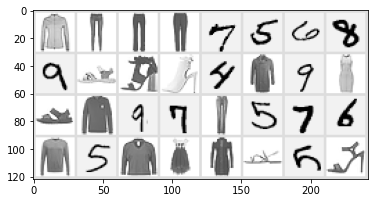

In [42]:
# create grid of images
dataiter = iter(fmnist_mnist_trainloader)
images, labels = dataiter.next()
img_grid = torchvision.utils.make_grid(images[0:32].view(-1, 1, 28, 28).type(torch.float))

print('Data samples')
# show images
imshow(img_grid, one_channel=True)

## Create imbalanced MNIST trainset

In [43]:
def imbalance_dataset(labels, fracs, selected_labels, size):
    
    unique_labels = torch.unique(labels)
    per_class_size = ceil(size/len(unique_labels))
    all_indices = []
    for l in unique_labels:
        indices = torch.where(labels == l)[0][0:per_class_size]
        if l in selected_labels:
            frac = fracs[np.random.randint(0,len(fracs),1)[0]]
        else:
            frac = 1.0
        selected_indices = list(np.random.choice(indices, int(frac*len(indices))))
        all_indices = all_indices + selected_indices
    return all_indices



In [44]:
fracs = [0.25,0.5,0.75, 1.0]
# fracs = [0.3]

imbalanced_indices = imbalance_dataset(trainset.targets, fracs, [0,1,2,3,4,6,7,8,9], trainsize*3) 

imbalanced_trainset = torch.utils.data.Subset(trainset,imbalanced_indices)

torch.save(imbalanced_trainset, open('data/imbalanced_dataset_5.data', 'wb'))

In [45]:
imbalanced_trainset = torch.load(open('data/imbalanced_dataset_5.data', 'rb'))

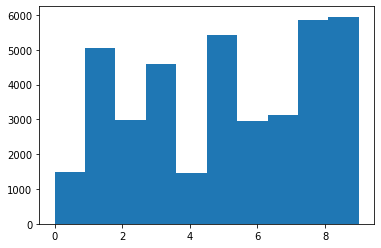

In [46]:
imbalanced_trainloader_all = torch.utils.data.DataLoader(imbalanced_trainset, 
                                                         batch_size=len(imbalanced_trainset),
                                                         shuffle=True, num_workers=1, pin_memory=True)
for _, labels in imbalanced_trainloader_all:
    plt.hist(labels.numpy(), align='mid')

In [47]:
imbalanced_trainloader = torch.utils.data.DataLoader(imbalanced_trainset, batch_size=64,
                                          shuffle=True, num_workers=1, pin_memory=True)

Data samples


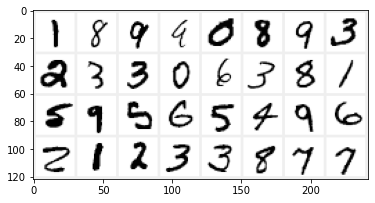

In [48]:
# create grid of images
dataiter = iter(imbalanced_trainloader)
images, labels = dataiter.next()
img_grid = torchvision.utils.make_grid(images[0:32].view(-1, 1, 28, 28).type(torch.float))

print('Data samples')
# show images
imshow(img_grid, one_channel=True)

## Define expert and gate networks

In [49]:
# Convolutional network with one convultional layer and 2 hidden layers with ReLU activation
class expert_layers(nn.Module):
    def __init__(self, num_classes):
        super(expert_layers, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3)
        self.fc1 = nn.Linear(in_features=1*13*13, out_features=5) # this is a pure linear transform
        self.fc2 = nn.Linear(in_features=5, out_features=10) # this is a pure linear transform
        
        self.out = nn.Linear(in_features=10, out_features=num_classes)
        
        self.num_classes = num_classes
        
    def forward(self, t):
        t = self.conv1(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        # fc1
        t = t.reshape(-1, 1*13*13)
        t = self.fc1(t)
        t = F.relu(t)

        # fc2
        t = self.fc2(t)
        t = F.relu(t)

        # output
        t = F.softmax(self.out(t), dim=1)
                
        return t

In [50]:
# Convolutional network with one convultional layer and 2 hidden layers with ReLU activation
class gate_layers(nn.Module):
    def __init__(self, num_experts):
        super(gate_layers, self).__init__()
        # define layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3)

        self.fc1 = nn.Linear(in_features=1*13*13, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=64)
        self.out = nn.Linear(in_features=64, out_features=num_experts)
        self.num_experts = num_experts

    def forward(self, t, T=1.0, y=None):
        # conv 1
        t = self.conv1(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        # fc1
        t = t.reshape(-1, 1*13*13)
            
        t = self.fc1(t)
        t = F.relu(t)

        # fc2
        t = self.fc2(t)
        t = F.relu(t)

        # output
        t = self.out(t)
        t = F.softmax(t/T, dim=1)
        return t


In [51]:
# create a set of experts
def experts(num_experts, num_classes, expert_layers_type=expert_layers):
    models = []
    for i in range(num_experts):
        models.append(expert_layers_type(num_classes))
    return nn.ModuleList(models)

## Initialize configurations and helper functions

In [52]:
def accuracy(out, yb, mean=True):
    preds = torch.argmax(out, dim=1).to(device, non_blocking=True)
    if mean:
        return (preds == yb).float().mean()
    else:
        return (preds == yb).float()

## Funtion to train MoR in: 
### (1) sample similarity regularization mode

In [53]:
from itertools import product

def train_model(model_1, model_info, trainloader, testloader, runs, temps=[[1.0]*20],
                                         w_sample_sim_same_range=[0.0],w_sample_sim_diff_range=[0.0], w_exp_gamma_range=[0.0],
                                         num_classes=10, total_experts=5, num_epochs=20):

    for T, w_sample_sim_same, w_sample_sim_diff, w_exp_gamma in product(temps, w_sample_sim_same_range, w_sample_sim_diff_range, w_exp_gamma_range):
        
        print('Temperature',['{:.1f}'.format(t) for t in T])
        if w_sample_sim_same < 1:
            print('w_sample_sim_same',str(w_sample_sim_same))
        else:
            print('w_sample_sim_same','{:.1f}'.format(w_sample_sim_same))
        
        if w_sample_sim_diff < 1:
            print('w_sample_sim_diff',str(w_sample_sim_diff))
        else:
            print('w_sample_sim_diff','{:.1f}'.format(w_sample_sim_diff))

            
        if w_exp_gamma < 1:
            print('w_exp_gamma',str(w_exp_gamma))
        else:
            print('w_exp_gamma','{:.1f}'.format(w_exp_gamma))

        n_run_models_1 = []
        for run in range(runs):

            print('Run:', run),
            models = {model_info['name']:{'model':model_info['model'],'loss':model_info['loss'], 'experts':{}}}

            for key, val in models.items():

                expert_models = experts(num_experts=total_experts, num_classes=num_classes).to(device)

                gate_model = gate_layers(num_experts=total_experts).to(device)

                moe_model = val['model'](num_experts=total_experts, num_classes=num_classes,
                                         experts=expert_models, gate=gate_model).to(device)
                
                if 'output_type' in model_info:
                    moe_model.type = model_info['output_type']

                optimizer_experts = optim.Adam(expert_models.parameters(), lr=0.001, amsgrad=False)

                optimizer_gate = optim.Adam(gate_model.parameters(), lr=0.001, amsgrad=False)
                
                optimizer_moe = optim.Adam(moe_model.parameters(), lr=0.001, amsgrad=False)

                hist = moe_model.train(trainloader, testloader,  val['loss'], optimizer_moe = optimizer_moe,
                                       optimizer_experts = optimizer_experts, optimizer_gate=optimizer_gate, 
                                       T = T, 
                                       w_sample_sim_same = w_sample_sim_same, w_sample_sim_diff = w_sample_sim_diff, 
                                       w_exp_gamma=w_exp_gamma,
                                       accuracy=accuracy, epochs=num_epochs, model_name=key)
                val['experts'][total_experts] = {'model':moe_model, 'history':hist}

            # Save all the trained models
            plot_file = generate_plot_file(model_1, T[0],w_sample_sim_same=w_sample_sim_same, w_sample_sim_diff=w_sample_sim_diff, w_exp_gamma=w_exp_gamma, specific=str(num_classes)+'_'+str(total_experts)+'_models.pt')

            if run > 1:
                n_run_models_1 = torch.load(open(os.path.join(model_path, plot_file),'rb'))
            n_run_models_1.append(models)

            torch.save(n_run_models_1,open(os.path.join(model_path, plot_file),'wb'))
            n_run_models_1 = []


In [54]:
def train_sample_sim_regularization_model(model_1, trainloader, testloader, runs, temps=[[1.0]*20],                                          
                                         w_sample_sim_same_range=[0.0],w_sample_sim_diff_range=[0.0], w_exp_gamma_range=[0.0],
                                         num_classes=10, total_experts=5, num_epochs=20):
    
    models = {'name':'moe_expectation_model','model':moe_expectation_model,'loss':cross_entropy_loss()}
    
    train_model(model_1, models, trainloader, testloader, runs, temps, 
                                         w_sample_sim_same_range,w_sample_sim_diff_range, w_exp_gamma_range,
                                         num_classes, total_experts, num_epochs)
    

In [55]:
from itertools import product

def train_dual_temp_regularization_stochastic_model(model_1, trainloader, testloader, runs, temps=[[1.0]*20], 
                                         w_importance_range=[0.0], w_ortho_range=[0.0], 
                                         w_sample_sim_same_range=[0.0],w_sample_sim_diff_range=[0.0], w_exp_gamma_range=[0.0],
                                         num_classes=10, total_experts=5, num_epochs=20):
    models = {'moe_stochastic_model':{'model':moe_stochastic_model,'loss':stochastic_loss(cross_entropy_loss),
                                               'experts':{}},}
    
    train_model(model_1, models, trainloader, testloader, runs, temps, 
                                         w_importance_range, w_ortho_range, 
                                         w_sample_sim_same_range,w_sample_sim_diff_range, w_exp_gamma_range,
                                         num_classes, total_experts, num_epochs)

In [56]:
def train_dual_temp_regularization_no_gate_model(model_1, output_type, trainloader, testloader, runs, temps=[[1.0]*20], no_gate_temps=[1.0],
                                         w_importance_range=[0.0], 
                                         num_classes=10, total_experts=5, num_epochs=20):
    
    models = {'name':'moe_no_gate_model', 'model':moe_no_gate_model,'output_type':output_type,'loss':stochastic_loss(cross_entropy_loss)}
    print('total_experts', total_experts)
    train_model(model_1, models, trainloader=trainloader, testloader=testloader, runs=runs, temps=temps, no_gate_temps=no_gate_temps,
                                         w_importance_range=w_importance_range, 
                                         num_classes=num_classes, total_experts=total_experts, num_epochs=num_epochs)
    

## Experiment 1: MoE model training with sample similarity regularization 

### MNIST data

In [53]:
# Model with gate and expert parameters initialized to default values
model_9 = 'mnist_with_reg'

In [54]:
total_experts = 5

In [55]:
num_epochs = 20

In [56]:
temps = [[1.0]*num_epochs]

In [57]:
w_sample_sim_same_range = [1e-5,1e-4,1e-3,1e-2,1e-1]
w_sample_sim_diff_range = [1e-5,1e-4,1e-3,1e-2,1e-1]
w_sample_sim_same_range, w_sample_sim_diff_range

([1e-05, 0.0001, 0.001, 0.01, 0.1], [1e-05, 0.0001, 0.001, 0.01, 0.1])

In [58]:
runs = 10

In [59]:
train_sample_sim_regularization_model(model_9, trainloader, testloader, runs, temps, 
                                     w_sample_sim_same_range=w_sample_sim_same_range,
                                     w_sample_sim_diff_range=w_sample_sim_diff_range,
                                     num_classes=num_classes, total_experts=total_experts, num_epochs=num_epochs)

Temperature ['1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']
w_sample_sim_same 1e-05
w_sample_sim_diff 1e-05
w_exp_gamma 0.0
Run: 0
epoch 0 training loss 5.13 , training accuracy 0.48 , test accuracy 0.74
epoch 1 training loss 3.90 , training accuracy 0.81 , test accuracy 0.84
epoch 2 training loss 3.61 , training accuracy 0.86 , test accuracy 0.88
epoch 3 training loss 3.50 , training accuracy 0.91 , test accuracy 0.92
epoch 4 training loss 3.43 , training accuracy 0.93 , test accuracy 0.93
epoch 5 training loss 3.39 , training accuracy 0.94 , test accuracy 0.94
epoch 6 training loss 3.37 , training accuracy 0.94 , test accuracy 0.95
epoch 7 training loss 3.36 , training accuracy 0.95 , test accuracy 0.94
epoch 8 training loss 3.35 , training accuracy 0.95 , test accuracy 0.95
epoch 9 training loss 3.33 , training accuracy 0.96 , test accuracy 0.95
epoch 10 training loss 3.33 , training accurac

### FMIST data

In [71]:
# Model with gate and expert parameters initialized to default values
model_9 = 'fmnist_with_reg'

In [72]:
total_experts = 5

In [73]:
num_epochs = 20

In [74]:
temps = [[1.0]*num_epochs]

In [75]:
w_sample_sim_same_range = [1e-5,1e-4,1e-3,1e-2,1e-1]
w_sample_sim_diff_range = [1e-5,1e-4,1e-3,1e-2,1e-1]
w_sample_sim_same_range, w_sample_sim_diff_range

([1e-05, 0.0001, 0.001, 0.01, 0.1], [1e-05, 0.0001, 0.001, 0.01, 0.1])

In [76]:
runs = 10

In [77]:
train_sample_sim_regularization_model(model_9, fmnist_trainloader, fmnist_testloader, runs, temps, 
                                     w_sample_sim_same_range=w_sample_sim_same_range,
                                     w_sample_sim_diff_range=w_sample_sim_diff_range,
                                     num_classes=num_classes, total_experts=total_experts, num_epochs=num_epochs)

Temperature ['1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']
w_sample_sim_same 1e-05
w_sample_sim_diff 1e-05
w_exp_gamma 0.0
Run: 0
epoch 0 training loss 4.68 , training accuracy 0.45 , test accuracy 0.62
epoch 1 training loss 3.58 , training accuracy 0.70 , test accuracy 0.73
epoch 2 training loss 3.37 , training accuracy 0.76 , test accuracy 0.76
epoch 3 training loss 3.29 , training accuracy 0.78 , test accuracy 0.77
epoch 4 training loss 3.24 , training accuracy 0.80 , test accuracy 0.79
epoch 5 training loss 3.21 , training accuracy 0.81 , test accuracy 0.80
epoch 6 training loss 3.18 , training accuracy 0.81 , test accuracy 0.80
epoch 7 training loss 3.16 , training accuracy 0.82 , test accuracy 0.81
epoch 8 training loss 3.13 , training accuracy 0.82 , test accuracy 0.81
epoch 9 training loss 3.11 , training accuracy 0.83 , test accuracy 0.82
epoch 10 training loss 3.10 , training accurac

### MNIST imbalanced data

In [144]:
# Model with gate and expert parameters initialized to default values
model_2 = 'mnist_imbalanced_multi_with_reg'

In [145]:
total_experts = 5

In [146]:
num_epochs = 20

In [147]:
num_classes = 10

In [148]:
temps = [[1.0]*num_epochs]

In [149]:
w_sample_sim_range = [1e-5,1e-4,1e-3,1e-2,1e-1]
w_sample_sim_range 

[1e-05, 0.0001, 0.001, 0.01, 0.1]

In [150]:
runs = 10

In [151]:
train_dual_temp_regularization_model(model_2, imbalanced_trainloader, testloader, runs, temps, 
                                     w_sample_sim_range=w_sample_sim_range, num_classes=num_classes, 
                                     total_experts=total_experts, num_epochs=num_epochs)

Temperature ['1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']
w_importance 0.0
w_ortho 0.0
w_sample_sim 1e-05
w_exp_gamma 0.0
Run: 0
epoch 0 training loss 1.19 , training accuracy 0.60 , test accuracy 0.74
epoch 1 training loss 0.37 , training accuracy 0.89 , test accuracy 0.87
epoch 2 training loss 0.23 , training accuracy 0.93 , test accuracy 0.89
epoch 3 training loss 0.19 , training accuracy 0.94 , test accuracy 0.91
epoch 4 training loss 0.15 , training accuracy 0.95 , test accuracy 0.90
epoch 5 training loss 0.12 , training accuracy 0.96 , test accuracy 0.91
epoch 6 training loss 0.11 , training accuracy 0.96 , test accuracy 0.90
epoch 7 training loss 0.09 , training accuracy 0.97 , test accuracy 0.92
epoch 8 training loss 0.08 , training accuracy 0.97 , test accuracy 0.92
epoch 9 training loss 0.07 , training accuracy 0.98 , test accuracy 0.92
epoch 10 training loss 0.06 , training accurac

### Combined rotated and unrotated MNIST data

In [61]:
# Model with gate and expert parameters initialized to default values
model_2 = 'rot_mnist_with_reg'

In [62]:
total_experts = 5

In [63]:
num_epochs = 20

In [64]:
num_classes = 10

In [65]:
temps = [[1.0]*num_epochs]

In [66]:
w_sample_sim_range = [1e-5,1e-4,1e-3,1e-2,1e-1]
w_sample_sim_range 

[1e-05, 0.0001, 0.001, 0.01, 0.1]

In [67]:
runs = 10

In [68]:
train_dual_temp_regularization_model(model_2, rot_unrot_trainloader, rot_unrot_testloader, runs,temps,
                                     w_sample_sim_range=w_sample_sim_range, num_classes=num_classes, 
                                     total_experts=total_experts, num_epochs=num_epochs)

Temperature ['1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']
w_importance 0.0
w_ortho 0.0
w_sample_sim 1e-05
w_exp_gamma 0.0
Run: 0
epoch 0 training loss 1.59 , training accuracy 0.43 , test accuracy 0.72
epoch 1 training loss 0.52 , training accuracy 0.87 , test accuracy 0.88
epoch 2 training loss 0.30 , training accuracy 0.91 , test accuracy 0.90
epoch 3 training loss 0.24 , training accuracy 0.93 , test accuracy 0.92
epoch 4 training loss 0.20 , training accuracy 0.94 , test accuracy 0.93
epoch 5 training loss 0.17 , training accuracy 0.95 , test accuracy 0.93
epoch 6 training loss 0.14 , training accuracy 0.96 , test accuracy 0.94
epoch 7 training loss 0.12 , training accuracy 0.96 , test accuracy 0.94
epoch 8 training loss 0.11 , training accuracy 0.96 , test accuracy 0.94
epoch 9 training loss 0.09 , training accuracy 0.97 , test accuracy 0.94
epoch 10 training loss 0.09 , training accurac

### Combined FMNIST MNIST data

In [86]:
# Model with gate and expert parameters initialized to default values
model_1 = 'fmnist_mnist_with_reg'

In [87]:
total_experts = 6

In [88]:
num_epochs = 20

In [89]:
temps = [[1.0]*num_epochs]
temps

[[1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0]]

In [90]:
w_sample_sim_same_range = [1e-5,1e-4,1e-3,1e-2,1e-1]
w_sample_sim_diff_range = [1e-5,1e-4,1e-3,1e-2,1e-1]
w_sample_sim_same_range, w_sample_sim_diff_range

([1e-05, 0.0001, 0.001, 0.01, 0.1], [1e-05, 0.0001, 0.001, 0.01, 0.1])

In [91]:
runs = 10

In [92]:
train_dual_temp_regularization_model(model_1, fmnist_mnist_trainloader, fmnist_mnist_testloader, 
                                     runs, temps, w_sample_sim_same_range=w_sample_sim_same_range, w_sample_sim_diff_range=w_sample_sim_diff_range, 
                                     num_classes=num_classes_fmnist_mnist, 
                                     total_experts=total_experts, num_epochs=num_epochs)

Temperature ['1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']
w_importance 0.0
w_ortho 0.0
w_sample_sim_same 1e-05
w_sample_sim_diff 1e-05
w_exp_gamma 0.0
Run: 0
epoch 0 training loss 2.27 , training accuracy 0.18 , test accuracy 0.28
epoch 1 training loss 1.20 , training accuracy 0.62 , test accuracy 0.72
epoch 2 training loss 0.67 , training accuracy 0.80 , test accuracy 0.79
epoch 3 training loss 0.50 , training accuracy 0.84 , test accuracy 0.82
epoch 4 training loss 0.43 , training accuracy 0.86 , test accuracy 0.84
epoch 5 training loss 0.39 , training accuracy 0.87 , test accuracy 0.85
epoch 6 training loss 0.36 , training accuracy 0.88 , test accuracy 0.84
epoch 7 training loss 0.34 , training accuracy 0.89 , test accuracy 0.85
epoch 8 training loss 0.31 , training accuracy 0.89 , test accuracy 0.86
epoch 9 training loss 0.30 , training accuracy 0.90 , test accuracy 0.86
epoch 10 training

## Experiment 10: MoE model training with sample similarity regularization  with gamma

### MNIST data

In [86]:
# Model with gate and expert parameters initialized to default values
model_10 = 'mnist_with_reg_test'

In [87]:
total_experts = 5

In [88]:
num_epochs = 20

In [89]:
temps = [[1.0]*num_epochs]

In [191]:
w_sample_sim_range = [i * 0.2 for i in range(1, 6)]
# w_sample_sim_range = [1.0]
w_sample_sim_range

[1.0]

In [192]:
w_exp_gamma_range = [1e-13, 1e-11, 1e-9 , 1e-7, 1e-5, 1e-3, 1e-1, 0.5, 1.0, 1000, 1000000]
w_exp_gamma_range = [1e-11, 1e-13]
w_exp_gamma_range 

[1e-11, 1e-13]

In [193]:
runs = 1

In [194]:
train_dual_temp_regularization_model(model_10, trainloader, testloader, runs, temps, 
                                     w_sample_sim_range=w_sample_sim_range, w_exp_gamma_range=w_exp_gamma_range,
                                     num_classes=num_classes, total_experts=total_experts, num_epochs=num_epochs)

Temperature ['1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']
w_importance 0.0
w_ortho 0.0
w_sample_sim 1.0
w_exp_gamma 1e-11
Run: 0
epoch 0 training loss -841.22 , training accuracy 0.68 , test accuracy 0.83
epoch 1 training loss -834.31 , training accuracy 0.88 , test accuracy 0.87
epoch 2 training loss -853.74 , training accuracy 0.91 , test accuracy 0.87
epoch 3 training loss -854.68 , training accuracy 0.92 , test accuracy 0.89
epoch 4 training loss -889.77 , training accuracy 0.93 , test accuracy 0.90
epoch 5 training loss -846.31 , training accuracy 0.93 , test accuracy 0.90
epoch 6 training loss -828.00 , training accuracy 0.93 , test accuracy 0.91
epoch 7 training loss -836.51 , training accuracy 0.94 , test accuracy 0.91
epoch 8 training loss -846.54 , training accuracy 0.94 , test accuracy 0.91
epoch 9 training loss -856.06 , training accuracy 0.95 , test accuracy 0.92
epoch 10 trainin

## Experiment 11: MoE model training with sample similarity and importance regularization 

### MNIST data

In [113]:
# Model with gate and expert parameters initialized to default values
model_11 = 'mnist_with_reg_test'

In [114]:
total_experts = 5

In [115]:
num_epochs = 20

In [116]:
temps = [[1.0]*num_epochs]

In [117]:
w_sample_sim_range = [i * 0.2 for i in range(1, 6)]
w_sample_sim_range = [1.0]
w_sample_sim_range

[1.0]

In [118]:
w_importance_range = [1.0]

In [119]:
runs = 1

In [120]:
train_dual_temp_regularization_model(model_11, trainloader, testloader, runs, temps, w_importance_range=w_importance_range, 
                                     w_sample_sim_range=w_sample_sim_range, num_classes=num_classes, 
                                     total_experts=total_experts, num_epochs=num_epochs)

Temperature ['1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']
w_importance 1.0
w_ortho 0.0
w_sample_sim 1.0
w_exp_gamma 0.0
Run: 0
epoch 0 training loss -843.85 , training accuracy 0.39 , test accuracy 0.53
epoch 1 training loss -843.86 , training accuracy 0.73 , test accuracy 0.72
epoch 2 training loss -875.56 , training accuracy 0.78 , test accuracy 0.75
epoch 3 training loss -878.69 , training accuracy 0.82 , test accuracy 0.77
epoch 4 training loss -896.14 , training accuracy 0.83 , test accuracy 0.80
epoch 5 training loss -895.03 , training accuracy 0.84 , test accuracy 0.74
epoch 6 training loss -902.75 , training accuracy 0.85 , test accuracy 0.81
epoch 7 training loss -915.99 , training accuracy 0.86 , test accuracy 0.80
epoch 8 training loss -928.80 , training accuracy 0.87 , test accuracy 0.82
epoch 9 training loss -921.17 , training accuracy 0.87 , test accuracy 0.82
epoch 10 training 

### Combined FMNIST MNIST data

In [130]:
# Model with gate and expert parameters initialized to default values
model_1 = 'fmnist_mnist_with_reg'

In [131]:
total_experts = 6

In [132]:
num_epochs = 20

In [133]:
temps = [[1.0]*num_epochs]
temps

[[1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0]]

In [134]:
w_sample_sim_range = [i * 0.2 for i in range(1, 6)]
w_sample_sim_range = [1.0]
w_sample_sim_range

[1.0]

In [135]:
w_importance_range = [1.0]

In [136]:
runs = 1

In [137]:
train_dual_temp_regularization_model(model_1, fmnist_mnist_trainloader, fmnist_mnist_testloader, 
                                     runs, temps, w_importance_range=w_importance_range,
                                     w_sample_sim_range=w_sample_sim_range, num_classes=num_classes_fmnist_mnist, 
                                     total_experts=total_experts, num_epochs=num_epochs)

Temperature ['1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']
w_importance 1.0
w_ortho 0.0
w_sample_sim 1.0
w_exp_gamma 0.0
Run: 0
epoch 0 training loss -753.65 , training accuracy 0.29 , test accuracy 0.52
epoch 1 training loss -760.10 , training accuracy 0.69 , test accuracy 0.70
epoch 2 training loss -760.25 , training accuracy 0.77 , test accuracy 0.76
epoch 3 training loss -750.74 , training accuracy 0.82 , test accuracy 0.80
epoch 4 training loss -756.48 , training accuracy 0.84 , test accuracy 0.81
epoch 5 training loss -774.27 , training accuracy 0.85 , test accuracy 0.80
epoch 6 training loss -762.73 , training accuracy 0.84 , test accuracy 0.82
epoch 7 training loss -760.94 , training accuracy 0.85 , test accuracy 0.82
epoch 8 training loss -753.57 , training accuracy 0.85 , test accuracy 0.82
epoch 9 training loss -757.91 , training accuracy 0.85 , test accuracy 0.81
epoch 10 training 

## Results

Min Validation Error 0.037
mnist_with_reg_sample_sim_same_1e-05_sample_sim_diff_1e-05_10_5_models.pt
20 torch.Size([20, 60000, 5])


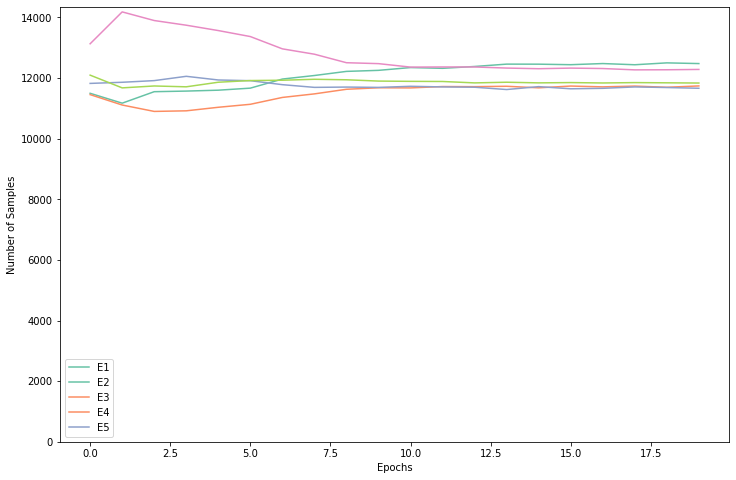

tensor([7, 2, 1,  ..., 4, 5, 6])


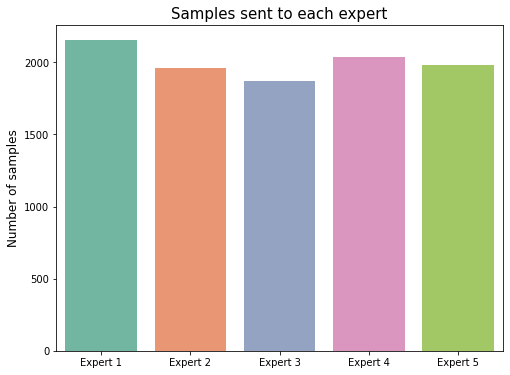

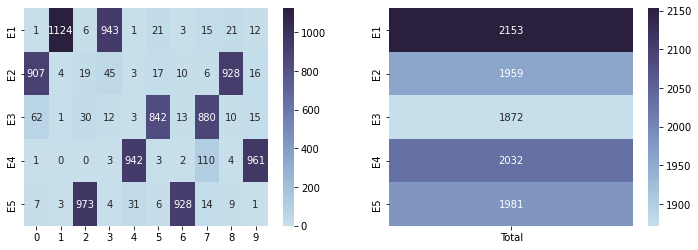


Experts used by the gate for classification of each digit


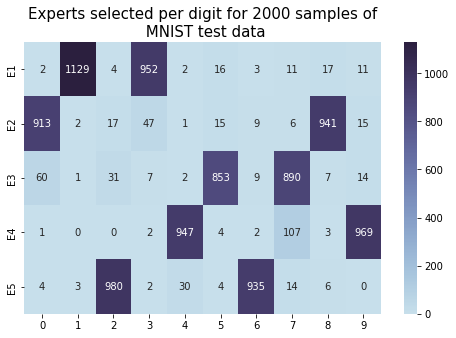

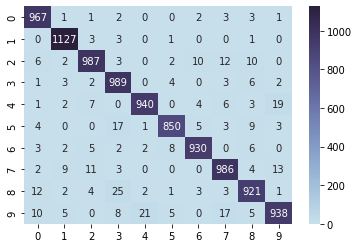

In [68]:
m = 'mnist_with_reg'

test_loader = testloader
total_experts = 5
num_classes = 10

w_importance_range = [i * 0.2 for i in range(1, 6)]

w_sample_sim_same_range = [1e-5,1e-4]
w_sample_sim_diff_range = [1e-5,1e-4]

plot_expert_usage(m, test_loader, w_importance_range=w_importance_range, w_sample_sim_same_range=w_sample_sim_same_range, w_sample_sim_diff_range=w_sample_sim_diff_range,
                  total_experts=total_experts, num_classes=num_classes, fig_path=fig_path, model_path=model_path )

Min Validation Error 0.134
fmnist_with_reg_importance_0.4_10_5_models.pt
20 torch.Size([20, 60000, 5])


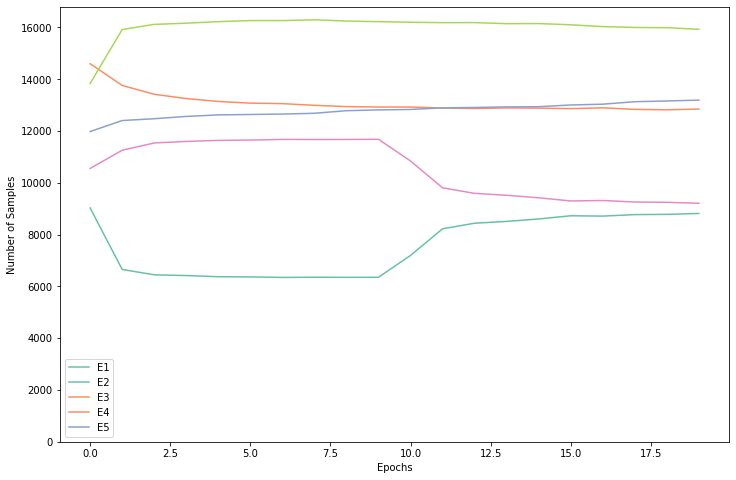

tensor([7, 9, 8,  ..., 8, 4, 7])


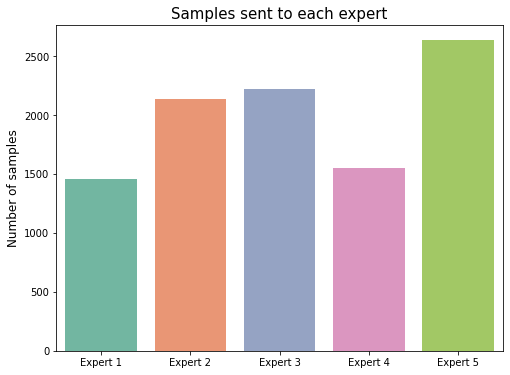

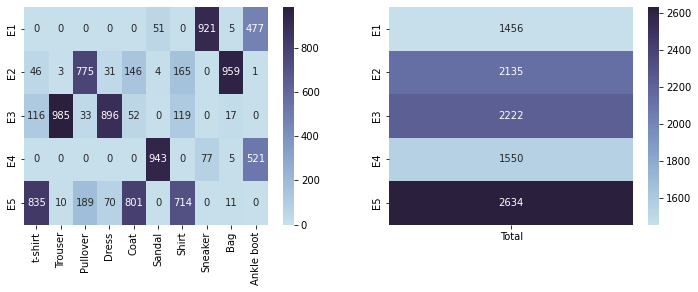


Experts used by the gate for classification of each digit


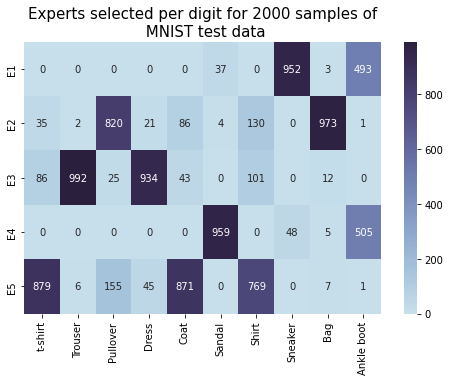

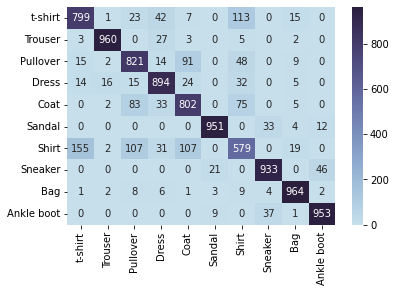

In [57]:
m = 'fmnist_with_reg'

test_loader = fmnist_testloader
total_experts = 5
num_classes = 10

w_importance_range = [i * 0.2 for i in range(1, 6)]

plot_expert_usage(m, test_loader, w_importance_range=w_importance_range, 
                  total_experts=total_experts, num_classes=num_classes, classes=classes_fmnist, fig_path=fig_path, model_path=model_path )

Min Validation Error 0.151
fmnist_with_reg_sample_sim_same_1e-05_sample_sim_diff_1e-05_10_5_models.pt
20 torch.Size([20, 60000, 5])


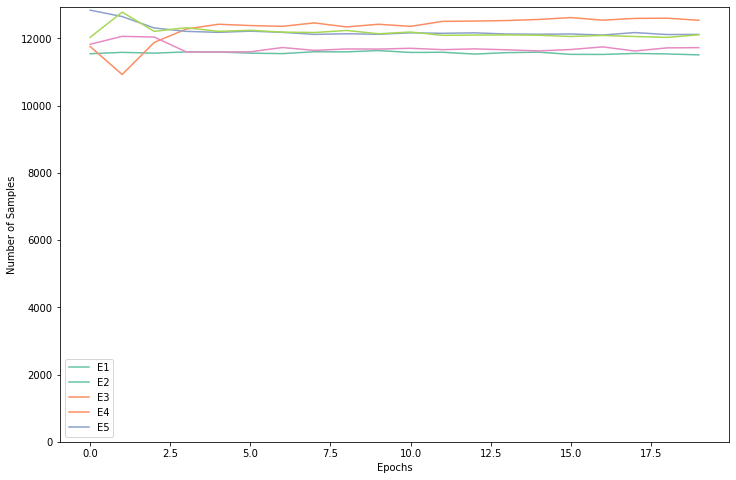

tensor([2, 0, 0,  ..., 9, 5, 2])


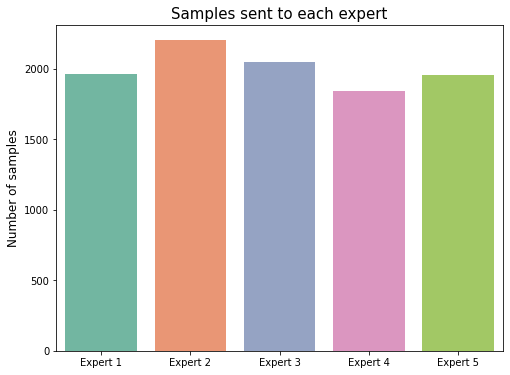

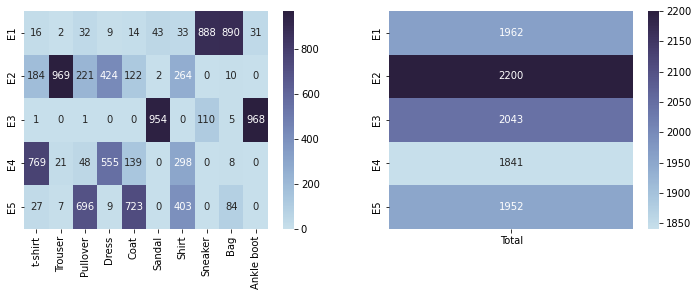


Experts used by the gate for classification of each digit


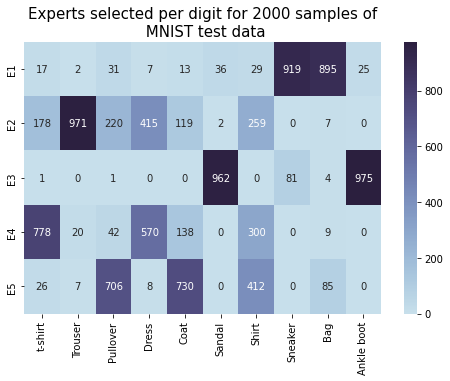

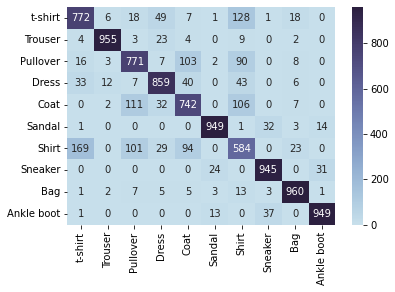

In [58]:
m = 'fmnist_with_reg'

test_loader = fmnist_testloader
total_experts = 5
num_classes = 10

w_importance_range = [i * 0.2 for i in range(1, 6)]
w_importance_range = []

w_sample_sim_same_range = [1e-5,1e-4]
w_sample_sim_diff_range = [1e-5,1e-4]

plot_expert_usage(m, test_loader, w_importance_range=w_importance_range, w_sample_sim_same_range=w_sample_sim_same_range, w_sample_sim_diff_range=w_sample_sim_diff_range,
                  total_experts=total_experts, num_classes=num_classes, classes=classes_fmnist, fig_path=fig_path, model_path=model_path )

w_importance_range [0.2, 0.4, 0.6000000000000001, 0.8, 1.0]


<Figure size 432x288 with 0 Axes>

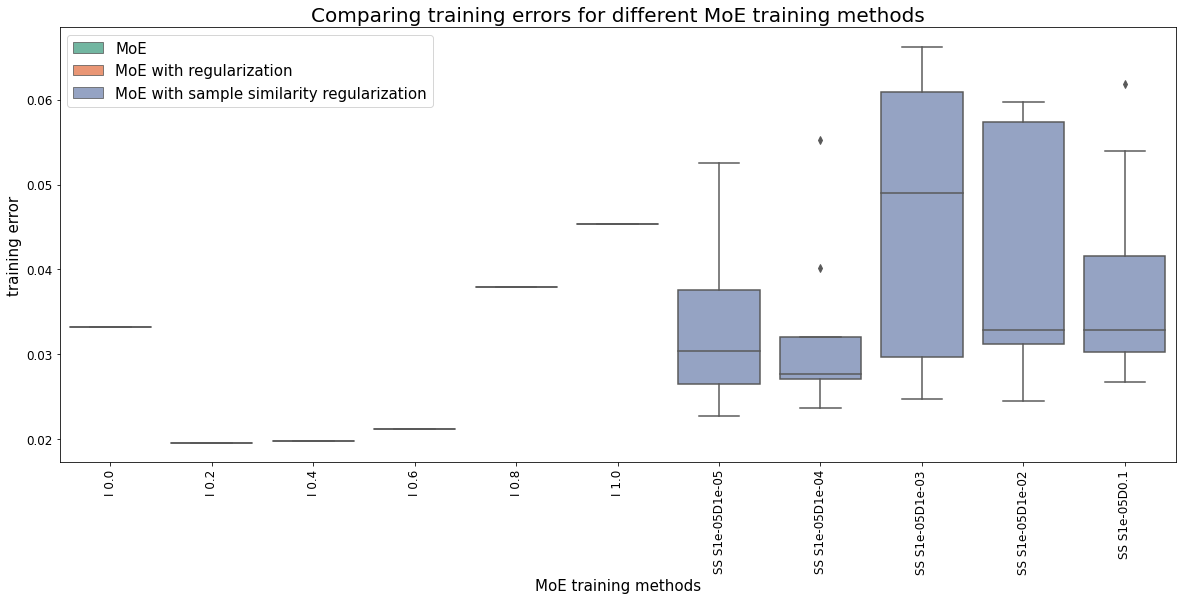

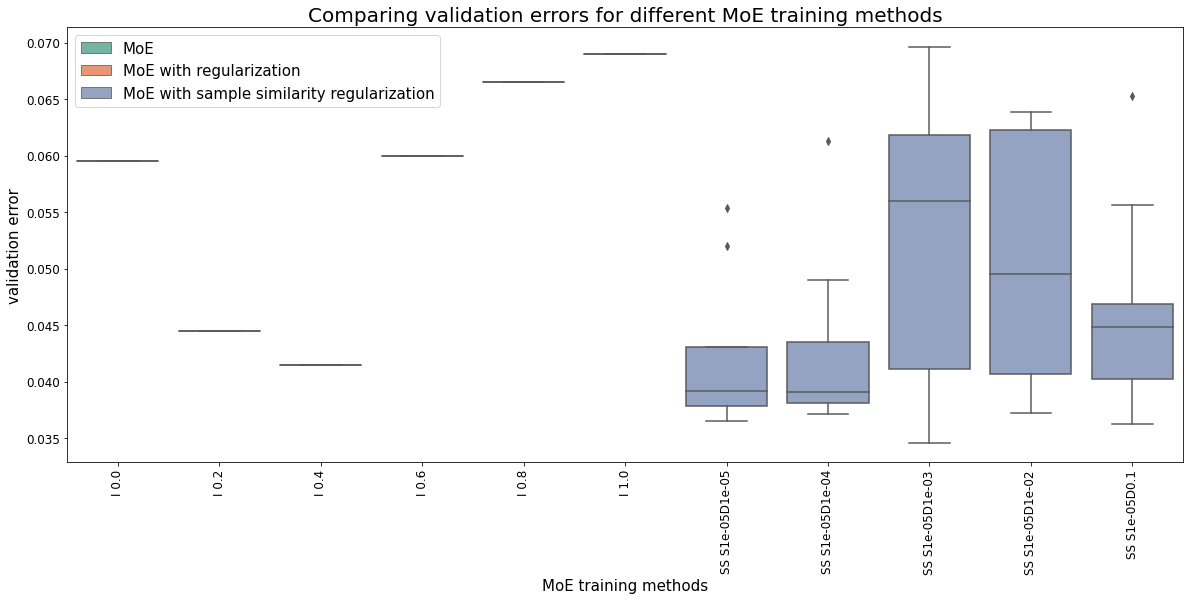

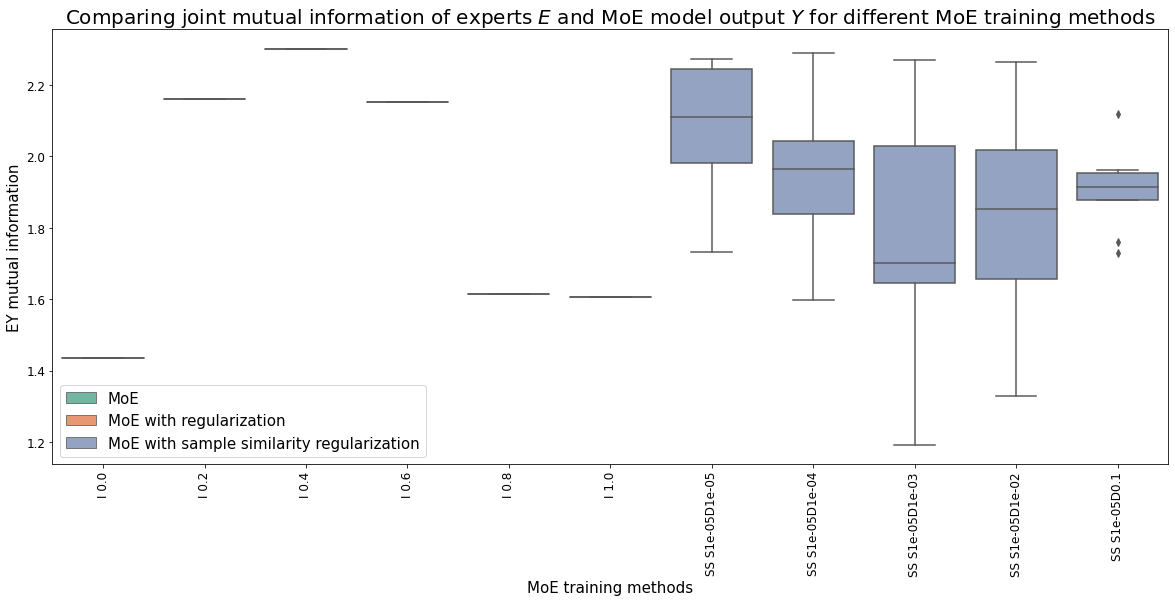

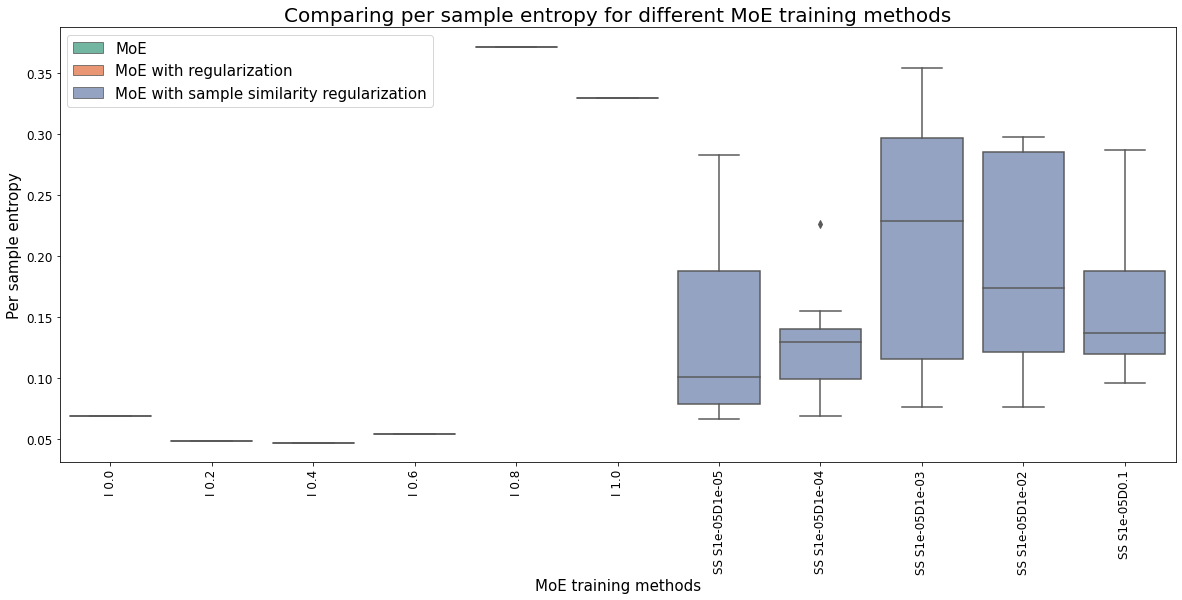

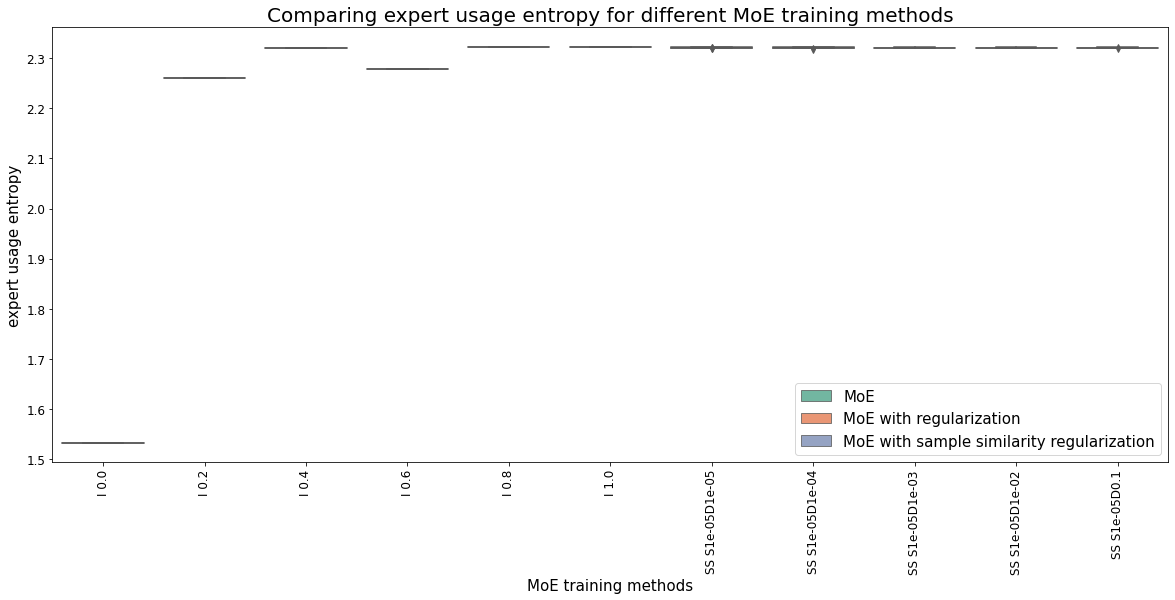

In [67]:
model_with_reg = {'ignore':'mnist_with_reg'}
model_sample_sim_reg = {'ignore':'mnist_with_reg'}
model_without_reg = {'ignore':'mnist_without_reg'}

figname = 'mnist_sample_sim'
total_experts = 5
num_classes = 10

w_importance_range = [i * 0.2 for i in range(1, 6)]
print('w_importance_range', w_importance_range)

w_sample_sim_same_range = [1e-5]
w_sample_sim_diff_range = [1e-5,1e-4,1e-3,1e-2,1e-1]
        
boxplot(
        model_with_reg=model_with_reg, model_without_reg=model_without_reg, 
        model_sample_sim_reg = model_sample_sim_reg, 
        w_importance_range=w_importance_range, w_sample_sim_same_range=w_sample_sim_same_range,
        w_sample_sim_diff_range = w_sample_sim_diff_range,
        total_experts=total_experts, num_classes=num_classes, classes=range(num_classes), 
        testloader=testloader, figname=figname, fig_path=fig_path, model_path=model_path)

w_importance_range [0.2, 0.4, 0.6000000000000001, 0.8, 1.0]


<Figure size 432x288 with 0 Axes>

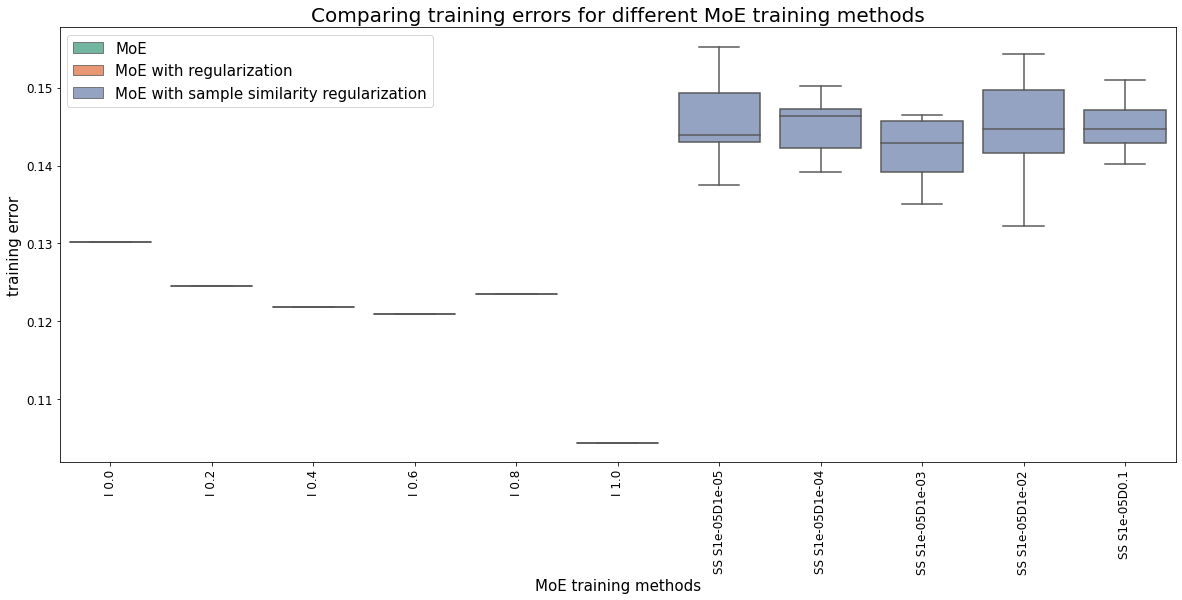

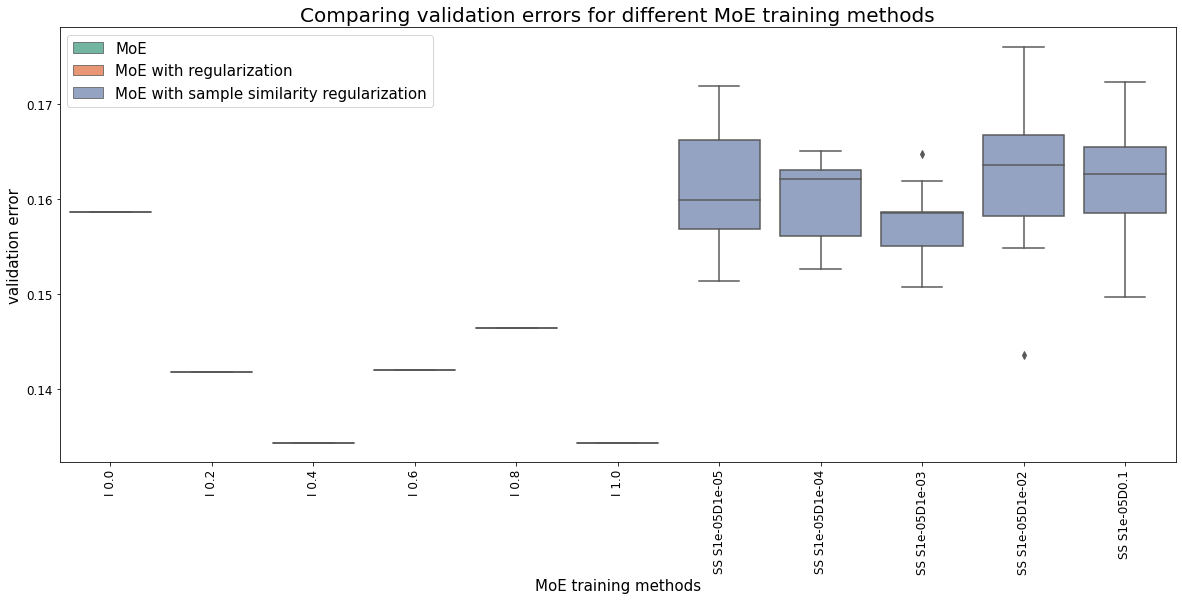

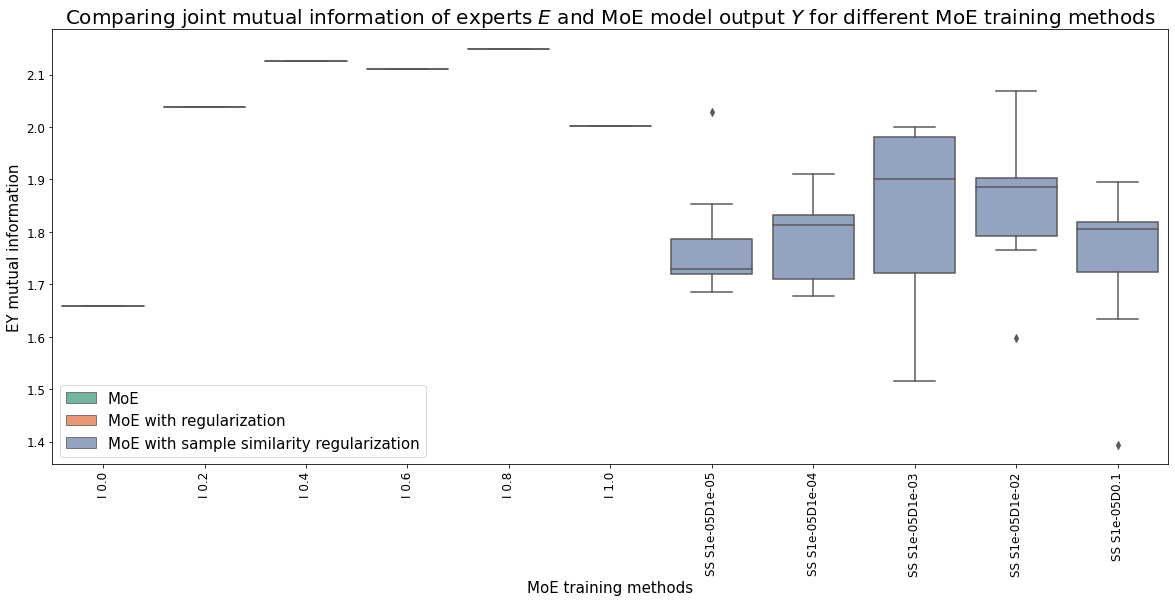

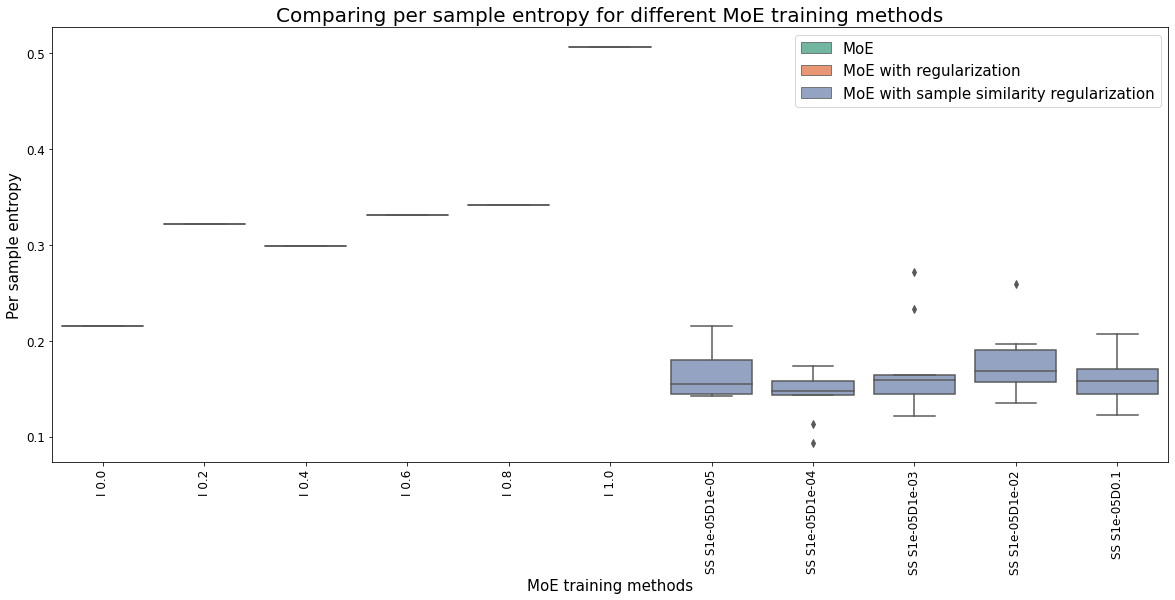

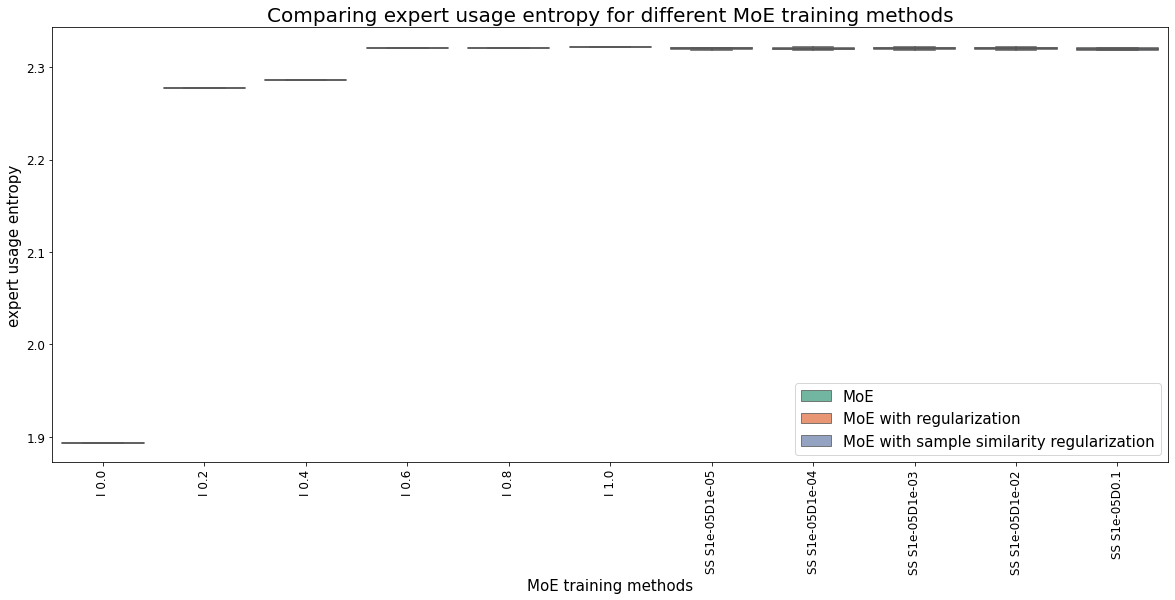

In [63]:
model_with_reg = {'ignore':'fmnist_with_reg'}
model_sample_sim_reg = {'ignore':'fmnist_with_reg'}
model_without_reg = {'ignore':'fmnist_without_reg'}

figname = 'fmnist_sample_sim'
total_experts = 5
num_classes = 10

w_importance_range = [i * 0.2 for i in range(1, 6)]
print('w_importance_range', w_importance_range)

w_sample_sim_same_range = [1e-5,1e-4,1e-3,1e-2,1e-1]
w_sample_sim_diff_range = [1e-5,1e-4,1e-3,1e-2,1e-1]
        
boxplot(
        model_with_reg=model_with_reg, model_without_reg=model_without_reg, 
        model_sample_sim_reg = model_sample_sim_reg, 
        w_importance_range=w_importance_range, w_sample_sim_same_range=w_sample_sim_same_range,
        w_sample_sim_diff_range = w_sample_sim_diff_range,
        total_experts=total_experts, num_classes=num_classes, classes=classes_fmnist, 
        testloader=fmnist_testloader, figname=figname, fig_path=fig_path, model_path=model_path)

### Results for MNIST data

In [ ]:
model_with_temp = 'mnist_dual_temp'
model_with_reg = 'mnist_with_regularization'
model_without_reg = 'mnist_without_regularization'
total_experts = 5
num_classes = 10
temps = np.concatenate((np.arange(1.1,1.6,0.1), np.arange(0.9,0.4,-0.1)))
w_importance_range = [i * 0.2 for i in range(1, 6)]

plot_results(model_with_temp, model_with_reg, model_without_reg, temps,w_importance_range,
             total_experts, num_classes, range(num_classes), testloader)

In [ ]:
model_with_temp = 'mnist_imbalanced_5_dual_temp'
model_with_reg = 'mnist_imbalanced_5_with_regularization'
model_without_reg = 'mnist_imbalanced_5_without_regularization'
total_experts = 5
num_classes = 10

temps = np.concatenate((np.arange(1.1,1.6,0.1), np.arange(0.9,0.4,-0.1)))
w_importance_range = [i * 0.2 for i in range(1, 6)]

plot_results(model_with_temp, model_with_reg, model_without_reg, temps,w_importance_range,
             total_experts, num_classes, range(num_classes), testloader)

In [ ]:
model_with_temp = 'rot_mnist_dual_temp'
model_with_reg = 'rot_mnist_with_regularization'
model_without_reg = 'rot_mnist_without_regularization'
total_experts = 5
num_classes = 10

temps = np.concatenate((np.arange(1.1,1.6,0.1), np.arange(0.9,0.4,-0.1)))
w_importance_range = [i * 0.2 for i in range(1, 6)]

rot_unrot_mnist_classes = ['0','1','2','3','4','rotated 0', 'rotated 1', 'rotated 2', 'rotated 3', 'rotated 4']
plot_results(model_with_temp, model_with_reg, model_without_reg, temps, w_importance_range,
             total_experts, num_classes,rot_unrot_mnist_classes , rot_unrot_testloader)

### Results for combined FMNIST and MNIST data

In [ ]:
model_with_temp = 'fmnist_mnist_dual_temp'
model_with_reg = 'fmnist_mnist_with_regularization'
model_without_reg = 'fmnist_mnist_without_regularization'
total_experts = 6

temps = np.concatenate((np.arange(1.1,1.6,0.1), np.arange(0.9,0.4,-0.1)))
w_importance_range = [i * 0.2 for i in range(1, 6)]

plot_results(model_with_temp, model_with_reg, model_without_reg, temps, w_importance_range,
             total_experts, num_classes_fmnist_mnist, classes_fmnist_mnist, fmnist_mnist_testloader)